# Preprocessing and splitting the breast cancer dataset

## Load the data

In [1]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('fico_full.csv')

In [3]:
data.shape

(10459, 24)

### Add additional synthetic missingness, Non-ignorable

In [4]:
added_missingness_num_cols = 1
added_missingness_rate = 0.2
np.random.seed(1896)

target_cols = np.random.choice(data.shape[1]-1, added_missingness_num_cols, replace=False)

inter_cols = np.random.choice(data.shape[1]-1, added_missingness_num_cols, replace=False)
targets = np.random.choice([0, 1], size=(data.shape[0], target_cols.shape[0]), p=[1-added_missingness_rate, added_missingness_rate])

for i, col in enumerate(target_cols):
    print(f"Adding missingness to: {data.columns[col]}")
    thresh_col = data.columns[inter_cols[i]]
    thresh_mask = data[thresh_col] >= data[thresh_col].quantile(0.6)
    tartget_labels = np.zeros_like(thresh_mask)
    tartget_labels[thresh_mask] = 1
    mask = (targets[:, i] == 1) & (data['PoorRiskPerformance'] == tartget_labels)
    data.loc[mask, data.columns[col]] = -10

Adding missingness to: NumInqLast6Mexcl7days


### Continue processing data

In [5]:
missing_val = [-7, -8, -9, -10]
data = data.replace(missing_val, np.nan)

In [6]:
data.isnull().sum()

PercentTradesWBalance                  606
ExternalRiskEstimate                   598
MSinceOldestTradeOpen                  827
MSinceMostRecentTradeOpen              588
AverageMInFile                         588
NumSatisfactoryTrades                  588
NumTrades60Ever2DerogPubRec            588
NumTrades90Ever2DerogPubRec            588
PercentTradesNeverDelq                 588
MSinceMostRecentDelq                  5428
MaxDelq2PublicRecLast12M               588
MaxDelqEver                            588
NumTotalTrades                         588
NumTradesOpeninLast12M                 588
PercentInstallTrades                   588
MSinceMostRecentInqexcl7days          2919
NumInqLast6M                           588
NumInqLast6Mexcl7days                 1411
NetFractionRevolvingBurden             774
NetFractionInstallBurden              4007
NumRevolvingTradesWBalance             744
NumInstallTradesWBalance              1449
NumBank2NatlTradesWHighUtilization    1171
PoorRiskPer

Features we could encode in a special way: 

- 'NumTrades60Ever2DerogPubRec' and other integer features: some have few enough distinct categories that we could treat them as ordinal, perhaps. 

- Percent and Fraction features do need to be constrained between 0 and 100. 


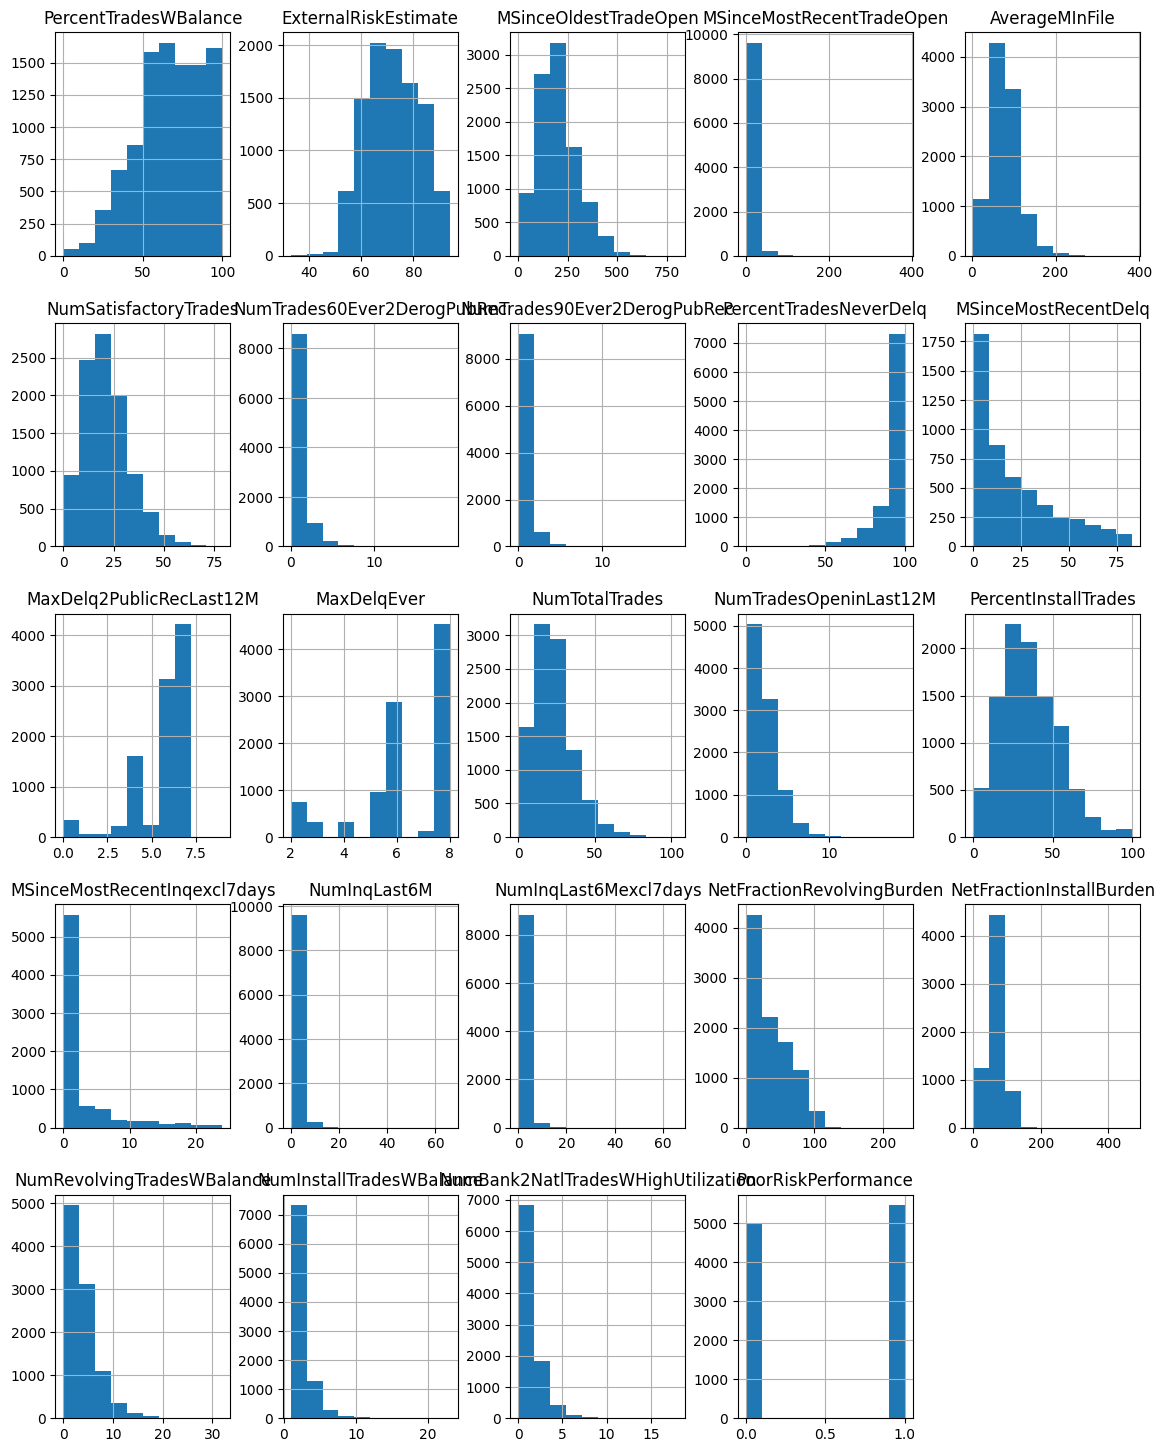

In [7]:
data.hist(figsize=(14, 18), layout=(5, 5));

### Create training, validation and holdout sets

In [8]:
outdir = Path('.')
outdir.mkdir(exist_ok=True)

n_splits = 5
n_folds = 10
idx = np.arange(len(data))

kf_splits = KFold(n_splits=n_splits, random_state=1896, shuffle=True)

for holdout_num, out_split in enumerate(kf_splits.split(idx)):
    idx_train = idx[out_split[0]]
    idx_test = idx[out_split[1]]
    devel_fold = data.iloc[idx_train, ]
    test_fold = data.iloc[idx_test, ]

    test_fold.to_csv(outdir / f'holdout_{holdout_num}.csv', index=False)

    kf_folds = KFold(n_splits=n_folds, random_state=165782 * holdout_num, shuffle=True)
    idx_folds = np.arange(len(devel_fold))
    for fold_num, idx_fold_split in enumerate(kf_folds.split(idx_folds)):
        train_fold = devel_fold.iloc[idx_fold_split[0]]
        val_fold = devel_fold.iloc[idx_fold_split[1]]
        train_fold.to_csv(outdir / f'devel_{holdout_num}_train_{fold_num}.csv', index=False)
        val_fold.to_csv(outdir / f'devel_{holdout_num}_val_{fold_num}.csv', index=False)